# Train a Neural Network to Detect Breast MRI Tumors with PyTorch part1
#A practical tutorial for medical image analysis

The tutorial used is by Nick Konz from the mazurowski-lab
 https://sites.duke.edu/mazurowski/2022/07/13/breast-mri-cancer-detect-tutorial-part1/
 code by Nick Konz (minor) ajustments by Stefan Seidel

Data downloaded from:
https://wiki.cancerimagingarchive.net/display/NBIA/Downloading+TCIA+Images
https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70226903

 Literature:
 Saha, A., Harowicz, M.R., Grimm, L.J., Kim, C.E., Ghate, S.V., Walsh, R. and Mazurowski, M.A., 2018. 
 A machine learning approach to radiogenomics of breast cancer: a study of 922 subjects and 529 DCE-MRI features. 
 British journal of cancer, 119(4), pp.508–516. (A free version of this paper is available here: PMC6134102)

In [1]:
!pip install numpy

In [2]:
!pip install pydicom

In [3]:
!pip install os

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [4]:
# first, load some necessary libraries
import pandas as pd
import numpy as np
import os
import pydicom
from tqdm import tqdm
from skimage.io import imsave
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.io import imread

In [5]:
# define useful file paths:
data_path = 'data/manifest-1674762954550'
boxes_path = 'data/Annotation_Boxes.csv'
mapping_path = 'data/Breast-Cancer-MRI-filepath_filename-mapping.csv'
target_png_dir = 'data/png_out'

if not os.path.exists(target_png_dir):
    os.makedirs(target_png_dir)

In [6]:
# load the bounding box annotation list and see what it looks like
boxes_df = pd.read_csv(boxes_path)
display(boxes_df) # needs to be in .ipynb/IPython notebook to work

,Patient ID,Start Row,End Row,Start Column,End Column,Start Slice,End Slice
0,Breast_MRI_001,234,271,308,341,89,112
1,Breast_MRI_002,251,294,108,136,59,72
2,Breast_MRI_003,351,412,82,139,96,108
3,Breast_MRI_004,262,280,193,204,86,95
4,Breast_MRI_005,188,213,138,178,76,122
...,...,...,...,...,...,...,...
917,Breast_MRI_918,345,395,338,395,62,85
918,Breast_MRI_919,285,312,369,397,98,109
919,Breast_MRI_920,172,193,337,355,87,101
920,Breast_MRI_921,328,374,404,446,97,121


Note that these MRIs are three-dimensional: they have coordinates of height (measured by pixel rows), width (measured by pixel columns), and depth (measured by the “slice” dimension). Here, Start Row, End Row, Start Column and End Column define the two-dimensional bounding box areas along the height-width pixel dimension where a tumor was found for each patient, while Start Slice and End Slice describe how far the bounding box/tumor extends in the depth (slice) dimension.

For simplicity, we will only consider fat-saturated MR exams: this can be accomplished by loading the image file path .csv list, and only keeping the subset of fat-saturated images:

In [7]:
# only consider fat-satured "pre" exams (for simplification purposes of the tutorial)
#    ("low_memory=False" is not a good solution but pevented error)
mapping_df = pd.read_csv(mapping_path , low_memory=False ) 
mapping_df = mapping_df[mapping_df['original_path_and_filename'].str.contains('pre')]

In [8]:
# remove entries from patients that we are not including (we only include patients 1 to 100)
# using a regex pattern
crossref_pattern = '|'.join(["DICOM_Images/Breast_MRI_{:03d}".format(s) for s in list(range(1, 101))])
mapping_df = mapping_df[mapping_df['original_path_and_filename'].str.contains(crossref_pattern)]

In [10]:
#mapping_df

Note that each row in mapping_df refers to a different 2D slice of a full 3D MRI volume.

Next, we are ready to write some code to automatically extract .png files from the raw DICOM data, as .png files work nicely with PyTorch (and take up much less space than DICOMs). First, however, we need to define our classification task, as the labels that we will assign to each extracted .png image are based on this task definition.

In [14]:
def save_dcm_slice(dcm_fname, label, vol_idx):        
    # create a path to save the slice .png file in, according to the original DICOM filename and target label
    
        # take last element of "dcm_fname" after '/' as seperator and replace 'dcm ending with '-{}.png' 
    png_path = dcm_fname.split('/')[-1].replace('.dcm', '-{}.png'.format(vol_idx))
    label_dir = 'pos' if label == 1 else 'neg'
    png_path = os.path.join(target_png_dir, label_dir, png_path)

    if not os.path.exists(os.path.join(target_png_dir, label_dir)):
        os.makedirs(os.path.join(target_png_dir, label_dir))

    if not os.path.exists(png_path):
        # only make the png image if it doesn't already exist (if you're running this after the first time)

        # load DICOM file with pydicom library
        try:
            dcm = pydicom.dcmread(dcm_fname)
        except FileNotFoundError:
            # fix possible errors in filename from list
            dcm_fname_split = dcm_fname.split('/')
            dcm_fname_end = dcm_fname_split[-1]
            assert dcm_fname_end.split('-')[1][0] == '0'

            dcm_fname_end_split = dcm_fname_end.split('-')
            dcm_fname_end = '-'.join([dcm_fname_end_split[0], dcm_fname_end_split[1][1:]])

            dcm_fname_split[-1] = dcm_fname_end
            dcm_fname = '/'.join(dcm_fname_split)
            dcm = pydicom.dcmread(dcm_fname)


        # convert DICOM into numerical numpy array of pixel intensity values (-> normalisation)
        img = dcm.pixel_array

        # convert uint16 datatype to float, scaled properly for uint8
        img = img.astype(float) * 255. / img.max()
        # convert from float -> uint8
        img = img.astype(np.uint8)
        # invert image if necessary, according to DICOM metadata
        img_type = dcm.PhotometricInterpretation
        if img_type == "MONOCHROME1":
            img = np.invert(img)

        # save final .png
        imsave(png_path, img)

Next, when converting each 2D slice to a .png, we’ll want to iterate over each 3D patient volume, as each volume is associated with a single breast tumor bounding box, as are all of the 2D slices (DICOMs) within that volume.

It is also important that the network is trained on a dataset that has a balanced amount of positive and negative class examples so that it doesn’t focus too heavily on one of the two classes (see our paper here for further discussion on the class imbalance problem). In total, we could extract a bit more than 2600 positive images from this dataset, and about 13500 negatives. As such, to maintain a class balance, we will extract exactly 2600 of each class.

This can be accomplished with the following code that iterates through mapping_df (the conversion will take some time):

In [15]:
# number of examples for each class
N_class = 2600
# counts of examples extracted from each class
ct_negative = 0
ct_positive = 0

# initialize iteration index of each patient volume
vol_idx = -1
for row_idx, row in tqdm(mapping_df.iterrows(), total=N_class*2):
    # indices start at 1 here
    new_vol_idx = int((row['original_path_and_filename'].split('/')[1]).split('_')[-1])
    slice_idx = int(((row['original_path_and_filename'].split('/')[-1]).split('_')[-1]).replace('.dcm', ''))

    # new volume: get tumor bounding box
    if new_vol_idx != vol_idx:
        box_row = boxes_df.iloc[[new_vol_idx-1]]
        start_slice = int(box_row['Start Slice'])
        end_slice = int(box_row['End Slice'])
        assert end_slice >= start_slice
    vol_idx = new_vol_idx

    # get DICOM filename
    dcm_fname = str(row['classic_path'])
    dcm_fname = os.path.join(data_path, dcm_fname)

    # determine slice label:
    # (1) if within 3D box, save as positive
    if slice_idx >= start_slice and slice_idx < end_slice: 
        if ct_positive >= N_class:
            continue
        save_dcm_slice(dcm_fname, 1, vol_idx)
        ct_positive += 1

    # (2) if outside 3D box by >5 slices, save as negative
    elif (slice_idx + 5) <= start_slice or (slice_idx - 5) > end_slice:
        if ct_negative >= N_class:
            continue
        save_dcm_slice(dcm_fname, 0, vol_idx)
        ct_negative += 1

17116it [09:08, 31.21it/s]                          


display one of the images

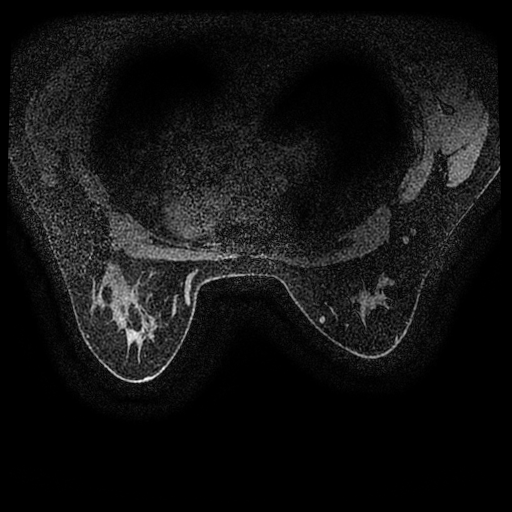

In [16]:
from IPython.display import Image, display
from random import choice

positive_image_dir = os.path.join(target_png_dir, 'pos')
negative_image_filenames = os.listdir(positive_image_dir)
sample_image_path = os.path.join(positive_image_dir, choice(negative_image_filenames))

display(Image(filename=sample_image_path))

Thanks to Nick Konz for this tutorial!!!

https://sites.duke.edu/mazurowski/2022/07/13/breast-mri-cancer-detect-tutorial-part1/